In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.options.display.max_columns = 100

In [3]:
PROJECT_ROOT = os.path.dirname(os.path.abspath(os.curdir))
INPUT_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'raw')
OUTPUT_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed')
INPUT_CSV_FILEPATH = os.path.join(INPUT_FILEPATH, 'diabetes.csv')
OUTPUT_CSV_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes.csv')
OUTPUT_PICKLE_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes.pkl')
OUTPUT_SINGLE_ENCOUNTER_CSV_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes--single-encounter.csv')
OUTPUT_SINGLE_ENCOUNTER_PICKLE_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes--single-encounter.pkl')

ID_MAPPINGS = ['admission_source_id', 'admission_type_id', 'discharge_disposition_id']

# Load diabetes data into a dataframe where encounter ID is the index
df = pd.read_csv(INPUT_CSV_FILEPATH, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


In [4]:
original_shape = df.shape

In [5]:
id_mappings = dict()

for c in ID_MAPPINGS:
    p = os.path.join(INPUT_FILEPATH, f'{c}_mappings.csv')
    id_mappings[c] = pd.read_csv(p)

In [6]:
def homogeneous_features(df):
    features = []
    for c in df.columns:
        v = df[c].value_counts().to_numpy()
        if np.count_nonzero(v) <= 1:
            features.append(c)
            
    return features

### 1. Handling Missing Values

Null values are encoded as '?' in the raw data, so we'll convert them to NumPy's NaN value to be able to use Pandas null/na methods.

In [7]:
# Convert '?' and 'None' values to numpy NaN
df[df == '?'] = np.nan
df[df == 'None'] = np.nan

We compare the proportions of NaN values of each feature to determine if each feature is worth considering for our predictive task.

In [8]:
df.isna().sum() / len(df)

patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
A1Cresult                   0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
g

The `weight` and `payer_code` (the ID that corresponds to the method that the patient used to pay for their treatment) have a high incidence of null or missing data.

In [9]:
df = df.drop(columns=['weight', 'payer_code'], errors='ignore')

## 2. Handling Ordinal and Nominal Features

### 2a. Ordinal features
* `age` - Age of the patient bucketed in intervals of 10 years 

In [10]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [11]:
# Convert age brackets into an integer between 0-9
age_mappings = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_mappings = dict(zip(age_mappings, range(0, len(age_mappings))))
df['age'] = df.age.map(age_mappings)

### 2b. Binary nominal features
 

In [12]:
binary_nominal_features = []
for c in df.columns:
    v = df[c].value_counts()
    
    if df[c].dtype == 'object' and v.shape[0] == 2:
        binary_nominal_features.append((c, v))
        
binary_nominal_features

[('acetohexamide',
  No        101765
  Steady         1
  Name: acetohexamide, dtype: int64),
 ('tolbutamide',
  No        101743
  Steady        23
  Name: tolbutamide, dtype: int64),
 ('troglitazone',
  No        101763
  Steady         3
  Name: troglitazone, dtype: int64),
 ('glipizide-metformin',
  No        101753
  Steady        13
  Name: glipizide-metformin, dtype: int64),
 ('glimepiride-pioglitazone',
  No        101765
  Steady         1
  Name: glimepiride-pioglitazone, dtype: int64),
 ('metformin-rosiglitazone',
  No        101764
  Steady         2
  Name: metformin-rosiglitazone, dtype: int64),
 ('metformin-pioglitazone',
  No        101765
  Steady         1
  Name: metformin-pioglitazone, dtype: int64),
 ('change',
  No    54755
  Ch    47011
  Name: change, dtype: int64),
 ('diabetesMed',
  Yes    78363
  No     23403
  Name: diabetesMed, dtype: int64)]

We can encode binary features like `change` and `diabetesMed` into a boolean value. Medication-related features circumstantially have two values but can take 4 possible values {up, down, steady, no}.

In [13]:
df.loc[df.change == 'No', 'change'] = 0
df.loc[df.change == 'Ch', 'change'] = 1

In [14]:
df.loc[df.diabetesMed == 'No', 'diabetesMed'] = 0
df.loc[df.diabetesMed == 'Yes', 'diabetesMed'] = 1

### 2c. Medication-related features
This dataset contains 23 medication names where its values are:
 - `Up`: The dosage was increased during the encounter
 - `Down`: The dosage was decreased during the encounter
 - `Steady`: The dosage remained unchanged
 - `No`: The drug was not prescribed
 
 Let's first verify that no medication-related features have values that are not in the value space above:


In [15]:
medication_values = {'Up', 'Down', 'Steady', 'No'}
medication_features = df.loc[:, 'metformin':'metformin-pioglitazone'].columns
for f in medication_features:
    counts = df[f].value_counts()
    values = set(list(counts.keys()))
    
    if len(values - medication_values) > 0:
        raise ValueError(f'feature {f} contains illegal value {values}')
    df[f] = pd.Categorical(df[f], categories=medication_values)
    
df[medication_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   metformin                 101766 non-null  category
 1   repaglinide               101766 non-null  category
 2   nateglinide               101766 non-null  category
 3   chlorpropamide            101766 non-null  category
 4   glimepiride               101766 non-null  category
 5   acetohexamide             101766 non-null  category
 6   glipizide                 101766 non-null  category
 7   glyburide                 101766 non-null  category
 8   tolbutamide               101766 non-null  category
 9   pioglitazone              101766 non-null  category
 10  rosiglitazone             101766 non-null  category
 11  acarbose                  101766 non-null  category
 12  miglitol                  101766 non-null  category
 13  troglitazone        

### 2d. Other nominal features
- `admission_type_id` - The purpose of admission. It comprises 9 values:

In [16]:
id_mappings['admission_type_id'].description.unique()

array(['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', nan,
       'Trauma Center', 'Not Mapped'], dtype=object)

In [17]:
df['admission_type_id'] = df.admission_type_id.map(dict(zip(id_mappings['admission_type_id'].admission_type_id, id_mappings['admission_type_id'].description)))
# Map all NULL values to Not Available
df.loc[df.admission_type_id.isnull(), 'admission_type_id'] = 'Not Available'
df['admission_type_id'] = df.admission_type_id.astype('category')
df.admission_type_id.value_counts(normalize=True)

Emergency        0.530531
Elective         0.185416
Urgent           0.181593
Not Available    0.099011
Not Mapped       0.003144
Trauma Center    0.000206
Newborn          0.000098
Name: admission_type_id, dtype: float64

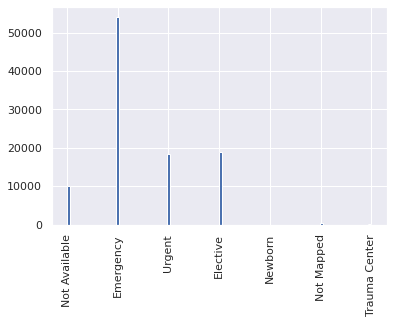

In [18]:
_ = plt.hist(df.admission_type_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `discharge_disposition_id` - patient discharge details if applicable

In [19]:
id_mappings['discharge_disposition_id'].description.unique()

array(['Discharged to home',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to SNF', 'Discharged/transferred to ICF',
       'Discharged/transferred to another type of inpatient care institution',
       'Discharged/transferred to home with home health service',
       'Left AMA',
       'Discharged/transferred to home under care of Home IV provider',
       'Admitted as an inpatient to this hospital',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Expired',
       'Still patient or expected to return for outpatient services',
       'Hospice / home', 'Hospice / medical facility',
       'Discharged/transferred within this institution to Medicare approved swing bed',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       nan, 'Expired at home. Medicaid only, hospice.',
       'Expired

In [20]:
df['discharge_disposition_id'] = df.discharge_disposition_id.map(dict(zip(id_mappings['discharge_disposition_id'].discharge_disposition_id, id_mappings['discharge_disposition_id'].description)))
df.loc[df.discharge_disposition_id.isnull(), 'discharge_disposition_id'] = 'Unknown/Invalid'
df['discharge_disposition_id'] = df.discharge_disposition_id.astype('category')
df.discharge_disposition_id.value_counts(normalize=True)

Discharged to home                                                                                           0.591887
Discharged/transferred to SNF                                                                                0.137118
Discharged/transferred to home with home health service                                                      0.126781
Unknown/Invalid                                                                                              0.036269
Discharged/transferred to another short term hospital                                                        0.020911
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.019584
Expired                                                                                                      0.016135
Discharged/transferred to another type of inpatient care institution                                         0.011635
Not Mapped                                              

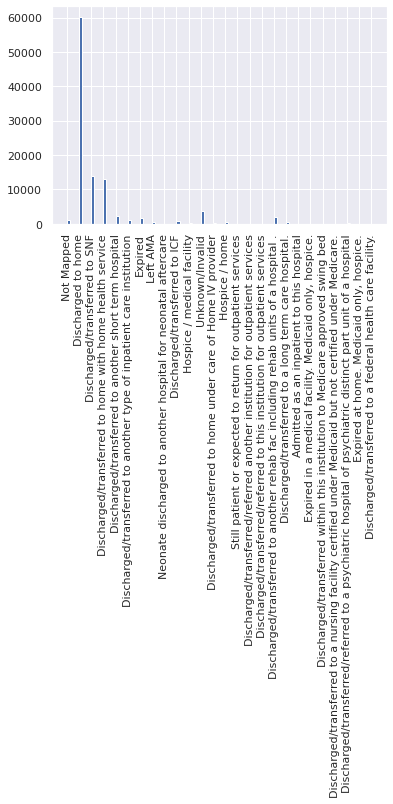

In [21]:
_ = plt.hist(df.discharge_disposition_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `admission_source_id` - Description of where the patient was admitted from for encounter

In [22]:
id_mappings['admission_source_id'].description.unique()

array([' Physician Referral', 'Clinic Referral', 'HMO Referral',
       'Transfer from a hospital',
       ' Transfer from a Skilled Nursing Facility (SNF)',
       ' Transfer from another health care facility', ' Emergency Room',
       ' Court/Law Enforcement', ' Not Available',
       ' Transfer from critial access hospital', 'Normal Delivery',
       ' Premature Delivery', ' Sick Baby', ' Extramural Birth',
       'Not Available', nan, ' Transfer From Another Home Health Agency',
       'Readmission to Same Home Health Agency', ' Not Mapped',
       'Unknown/Invalid',
       ' Transfer from hospital inpt/same fac reslt in a sep claim',
       ' Born inside this hospital', ' Born outside this hospital',
       ' Transfer from Ambulatory Surgery Center',
       'Transfer from Hospice'], dtype=object)

In [23]:
df['admission_source_id'] = df.admission_source_id.map(dict(zip(id_mappings['admission_source_id'].admission_source_id, id_mappings['admission_source_id'].description)))
df.loc[df.admission_source_id.isnull(), 'admission_source_id'] = 'Not Available'
df['admission_source_id'] = df.admission_source_id.astype('category')
df.admission_source_id.value_counts(normalize=True)

 Emergency Room                                               0.564963
 Physician Referral                                           0.290519
Not Available                                                 0.066633
Transfer from a hospital                                      0.031317
 Transfer from another health care facility                   0.022247
Clinic Referral                                               0.010848
 Transfer from a Skilled Nursing Facility (SNF)               0.008402
HMO Referral                                                  0.001838
 Not Mapped                                                   0.001582
 Not Available                                                0.001228
 Court/Law Enforcement                                        0.000157
 Transfer from hospital inpt/same fac reslt in a sep claim    0.000118
 Transfer from critial access hospital                        0.000079
 Transfer from Ambulatory Surgery Center                      0.000020
Normal

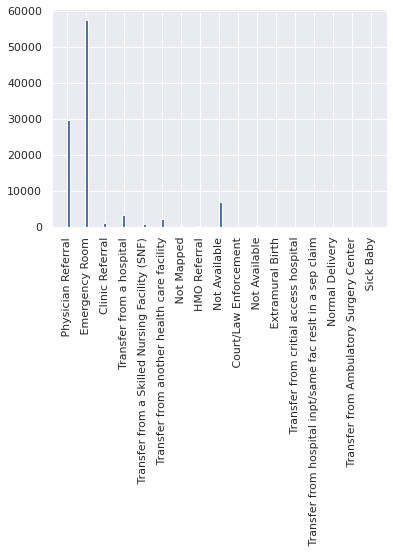

In [24]:
_ = plt.hist(df.admission_source_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `diag_1`, `diag_2`, `diag_3` - The primary, secondary, and tertiary diagnoses for the patient

These are nominal values that are represented by distinct integer values. We should convert these to categorical.

In [25]:
df['diag_1'] = df['diag_1'].astype('category')
df['diag_2'] = df['diag_2'].astype('category')
df['diag_3'] = df['diag_3'].astype('category')

- `gender` - The gender of the patient

In [26]:
df.gender.value_counts(normalize=True)

Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64

In [27]:
df[df.gender == 'Unknown/Invalid']

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98634858,100695042,Other,Unknown/Invalid,7,Elective,Discharged to home,Physician Referral,1,Cardiology,5,5,22,0,0,0,414,411,401,4,NaN,NaN,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO
226864668,60524946,NaN,Unknown/Invalid,6,Emergency,Discharged to home,Emergency Room,1,NaN,38,1,6,0,0,0,808,873,E813,5,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,NO
257364294,78119847,NaN,Unknown/Invalid,7,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room,8,NaN,59,2,21,0,0,0,850,805,808,9,NaN,NaN,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO


In [28]:
df['gender'] = df.gender.astype('category')

- `race` - The race/ethnicity of the patient

In [29]:
df.race.value_counts(normalize=True)

Caucasian          0.764868
AfricanAmerican    0.193079
Hispanic           0.020474
Other              0.015137
Asian              0.006443
Name: race, dtype: float64

In [30]:
df['race'] = df.race.astype('category')

- `readmitted` - if the patient was readmitted back into the hospital {NO (not readmitted), <30 (readmitted within less than days, >30 (readmitted after more than 30 days)}

In [31]:
df.readmitted.value_counts(normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [32]:
df['is_readmitted'] = df['readmitted']
df.loc[df.is_readmitted == 'NO', 'is_readmitted'] = 0
df.loc[((df.is_readmitted == '>30') | (df.is_readmitted == '<30')), 'is_readmitted'] = 1
df['is_readmitted'] = df.is_readmitted.astype(int)

df['is_readmitted_early'] = df['readmitted']
df.loc[((df.is_readmitted_early == 'NO') | (df.is_readmitted_early == '>30')), 'is_readmitted_early'] = 0
df.loc[df.is_readmitted_early == '<30', 'is_readmitted_early'] = 1
df['is_readmitted_early'] = df.is_readmitted_early.astype(int)

In [33]:
df['readmitted'] = df.readmitted.astype('category')

- `max_glu_serum` - Results for a test to measure the amount of glucose in the patient's blood (milligrams/deciliter), e.g. {None (test not taken), Norm (normal level of blood glucose), >200 (mg/dL), >300 (mg/dL)}. A glucose level over 200 mg/dL typically indicates diabetes.

In [34]:
df.max_glu_serum.value_counts(normalize=True)

Norm    0.485784
>200    0.277778
>300    0.236438
Name: max_glu_serum, dtype: float64

### 3. Handling outliers in continuous features
- `time_in_hospital` - The number of days patient was in the hospital

We should rename this column for more clarity.

In [35]:
df = df.rename(columns={'time_in_hospital': 'days_in_hospital'})

In [36]:
continuous_features = df._get_numeric_data().drop(columns=['patient_nbr', 'is_readmitted', 'is_readmitted_early'])
continuous_features.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,6.096702,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.594084,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,5.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,6.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,9.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


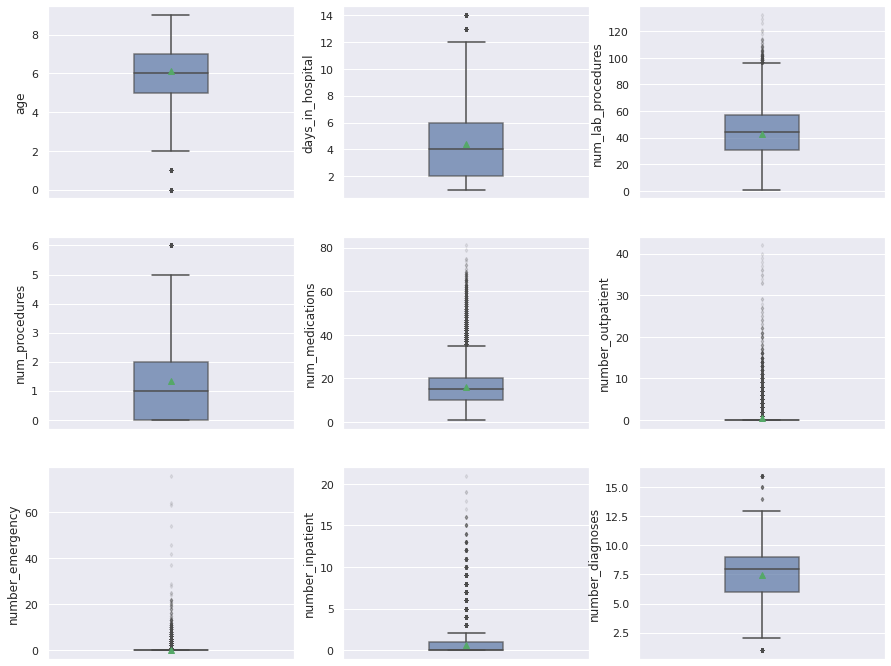

In [37]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(12)
fig.set_figwidth(15)

for i, c in enumerate(continuous_features.columns):
    _ = sns.boxplot(y=c, data=continuous_features, ax=axes[i//3, i%3],
                    showmeans=True, boxprops=dict(alpha=.7), width=.3,
                    flierprops=dict(markersize=3,alpha=0.1,
              linestyle='none'))

In [38]:
def outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1
    minx = q1 - 1.5*iqr
    maxx = q3 + 1.5*iqr
    return df[(df[feature] > maxx) | (df[feature] < minx)]

In [39]:
feature_outliers = dict()
for i, c in enumerate(continuous_features.columns):
    num_outliers = outliers(df, c).shape[0]
    feature_outliers[c] = num_outliers
feature_outliers

{'age': 852,
 'days_in_hospital': 2252,
 'num_lab_procedures': 143,
 'num_procedures': 4954,
 'num_medications': 2557,
 'number_outpatient': 16739,
 'number_emergency': 11383,
 'number_inpatient': 7049,
 'number_diagnoses': 281}

### 4. Entry independence

In [40]:
single_encounter_df = df.sort_values(by='encounter_id', axis='index').drop_duplicates(subset=['patient_nbr'], keep='first')
single_encounter_df = single_encounter_df.reset_index()
single_encounter_df = single_encounter_df.set_index(['encounter_id', 'patient_nbr'])
single_encounter_df.shape

(71518, 48)

In [41]:
feature_outliers = dict()
for i, c in enumerate(continuous_features.columns):
    num_outliers = outliers(single_encounter_df, c).shape[0]
    feature_outliers[c] = num_outliers
feature_outliers

{'age': 689,
 'days_in_hospital': 1464,
 'num_lab_procedures': 114,
 'num_procedures': 3956,
 'num_medications': 1925,
 'number_outpatient': 9306,
 'number_emergency': 5204,
 'number_inpatient': 8441,
 'number_diagnoses': 236}

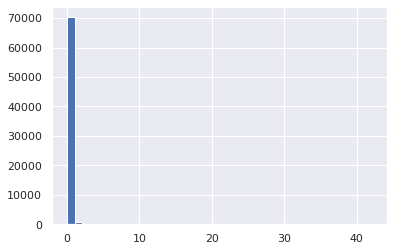

In [42]:
_ = single_encounter_df.number_emergency.hist(bins=40)

In [43]:
single_encounter_df.number_emergency.value_counts()

0     66314
1      3965
2       804
3       246
4        96
5        33
6        26
8         9
7         8
10        5
9         4
11        2
13        1
16        1
20        1
25        1
37        1
42        1
Name: number_emergency, dtype: int64

<AxesSubplot:>

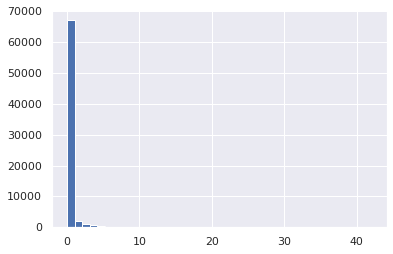

In [44]:
single_encounter_df.number_outpatient.hist(bins=40)

In [45]:
single_encounter_df.number_outpatient.value_counts()

0     62212
1      4867
2      2025
3      1116
4       585
5       288
6       128
7        73
8        57
9        37
10       28
11       19
12       14
13       13
14       10
15       10
16        8
17        4
20        4
18        2
21        2
22        2
24        2
27        2
33        2
19        1
23        1
25        1
26        1
29        1
35        1
36        1
42        1
Name: number_outpatient, dtype: int64

In [46]:
features_with_homogeneity = homogeneous_features(single_encounter_df)
single_encounter_df = single_encounter_df.drop(columns=features_with_homogeneity)
features_with_homogeneity

['examide', 'citoglipton', 'glimepiride-pioglitazone']

### 5. Save preprocessed data
Save the pre-processed data into a csv and pickle file.

In [47]:
original_shape, df.shape

((101766, 49), (101766, 49))

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101766 non-null  int64   
 1   race                      99493 non-null   category
 2   gender                    101766 non-null  category
 3   age                       101766 non-null  int64   
 4   admission_type_id         101766 non-null  category
 5   discharge_disposition_id  101766 non-null  category
 6   admission_source_id       101766 non-null  category
 7   days_in_hospital          101766 non-null  int64   
 8   medical_specialty         51817 non-null   object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency    

In [49]:
df.to_csv(OUTPUT_CSV_FILEPATH)

In [50]:
df.to_pickle(OUTPUT_PICKLE_FILEPATH)

In [51]:
single_encounter_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71518 entries, (12522, 48330783) to (443867222, 175429310)
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69570 non-null  category
 1   gender                    71518 non-null  category
 2   age                       71518 non-null  int64   
 3   admission_type_id         71518 non-null  category
 4   discharge_disposition_id  71518 non-null  category
 5   admission_source_id       71518 non-null  category
 6   days_in_hospital          71518 non-null  int64   
 7   medical_specialty         37041 non-null  object  
 8   num_lab_procedures        71518 non-null  int64   
 9   num_procedures            71518 non-null  int64   
 10  num_medications           71518 non-null  int64   
 11  number_outpatient         71518 non-null  int64   
 12  number_emergency          71518 non-null  int64   
 13  number_inpati

In [52]:
single_encounter_df.to_csv(OUTPUT_SINGLE_ENCOUNTER_CSV_FILEPATH)

In [53]:
single_encounter_df.to_pickle(OUTPUT_SINGLE_ENCOUNTER_PICKLE_FILEPATH)